In [8]:
# Need 70Gb memory to run this as peaks at just over 60gb RAM

In [77]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from useful_funcs import parse_data_dfs, make_timeseries
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import sys

di_df, pi_df, ti_df, dp_df, pp_df, tp_df = parse_data_dfs()
imperfect_final_rivs, perfect_final_rivs = list(di_df), list(dp_df)

print('Collected all base dataframes')
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

dtrain_df = di_df.loc[:, train_rivs]
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]

print('Transforming dataframes into timeseries dataframe')
data_days = 49
future_days = 14
rivers_to_consider = 300  # up to 1816 rivers but will be slower


def slide_window_riv(riv):
    rolling_period = data_days+future_days
    imp = riv in list(di_df)
    d = di_df[riv].rolling(
        rolling_period) if imp else dp_df[riv].rolling(rolling_period)
    p = pi_df[riv].rolling(
        rolling_period) if imp else pp_df[riv].rolling(rolling_period)
    t = ti_df[riv].rolling(
        rolling_period) if imp else tp_df[riv].rolling(rolling_period)
    all_features = []

    # sliding window through depth, pressure and temp
    for idx, (rd, rp, rt) in enumerate(zip(d, p, t)):
        # rolling window initially not full
        if len(rd) != rolling_period:
            continue
        # https://stats.stackexchange.com/questions/35304/how-to-standardize-an-array-if-standard-deviation-is-zero
        rd_d = rd.values[:data_days]
        # rd_m, rd_std = np.mean(rd_d), np.std(rd_d) if np.std(rd_d) != 0 else 1
        rd_min, rd_max = np.min(rd_d), np.max(rd_d)
        rd_denom = (rd_max - rd_min) if (rd_max - rd_min) != 0 else 1

        rp_d = rp.values[:data_days]
        # rp_m, rp_std = np.mean(rp_d), np.std(rp_d) if np.std(rp_d) != 0 else 1
        rp_min, rp_max = np.min(rp_d), np.max(rp_d)
        rp_denom = (rp_max - rp_min) if (rp_max - rp_min) != 0 else 1

        rt_d = rt.values[:data_days]
        # rt_m, rt_std = np.mean(rt_d), np.std(rt_d) if np.std(rt_d) != 0 else 1
        rt_min, rt_max = np.min(rt_d), np.max(rt_d)
        rt_denom = (rt_max - rt_min) if (rt_max - rt_min) != 0 else 1

        feature_data = np.concatenate((rd_d, rp_d, rt_d))
        # feature_data = np.concatenate(
        #     ((rd_d-rd_m)/rd_std, (rp_d-rp_m)/rp_std, (rt_d-rt_m)/rt_std))
        # feature_data = np.concatenate(
        #     ((rd_d-rd_min)/rd_denom, (rp_d-rp_min)/rp_denom, (rt_d-rt_min)/rt_denom))
        features = [rd.values[-1], riv, idx] + list(feature_data)
        # features = [(rd.values[-1]-rd_min)/rd_denom, riv, idx] + list(feature_data)
        all_features.append(features)
    return all_features


all_rivs = list(di_df) + list(dp_df)
X_train_df, X_val_df, X_test_df = make_timeseries(
    all_rivs[:rivers_to_consider], train_rivs, validate_rivs, slide_window_riv, data_days)
X_train_df['year_sin'] = np.sin(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_train_df['year_cos'] = np.cos(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_sin'] = np.sin(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_cos'] = np.cos(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_sin'] = np.sin(X_test_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_cos'] = np.cos(X_test_df['river_day'] * (2 * np.pi / 365.2425))


Collected all base dataframes
Transforming dataframes into timeseries dataframe


Reassigning river data to correct frame: 100%|██████████| 300/300 [00:16<00:00, 17.94it/s]


Training data made
Training data sorted
Validation data made
Validation data sorted
Test data made
Test data sorted


In [10]:
gc.collect()
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

tot_size = sizeof_fmt(sum([sys.getsizeof(value) for name, value in globals().items()]))
print(f'Current total size of variables is {tot_size} ... who knows what rest is!')
# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

Current total size of variables is 866.3 MiB ... who knows what rest is!


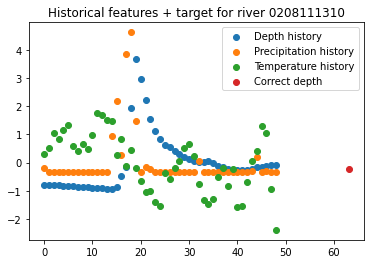

In [11]:
# What input and prediction looks like looks like
rowIdx = 42
y_point = X_train_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_train_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_train_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_train_df.iloc[rowIdx, :][all_ts].to_list()
plt.scatter(range(data_days), d_points, label='Depth history')
plt.scatter(range(data_days), p_points, label='Precipitation history')
plt.scatter(range(data_days), t_points, label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.legend()
riv_name = X_train_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.show()


In [12]:
# Baseline model
model = Sequential([
    Dense(1, input_shape=np.array(X_val_df.columns[3:]).shape)
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, [0]], epochs=1000,
                    batch_size=10000,
                    validation_split=0.2)


Epoch 1/1000
21/21 [==============================] - 1s 17ms/step - loss: 69.1144 - mean_absolute_error: 2.1048 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 2/1000
21/21 [==============================] - 0s 7ms/step - loss: 68.5084 - mean_absolute_error: 1.9891 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 3/1000
21/21 [==============================] - 0s 7ms/step - loss: 68.1078 - mean_absolute_error: 1.9125 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 4/1000
21/21 [==============================] - 0s 7ms/step - loss: 67.8062 - mean_absolute_error: 1.8560 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 5/1000
21/21 [==============================] - 0s 8ms/step - loss: 67.5715 - mean_absolute_error: 1.8125 - val_loss: 7443387703438581809024467992576.0000 - val_

Really poor performance


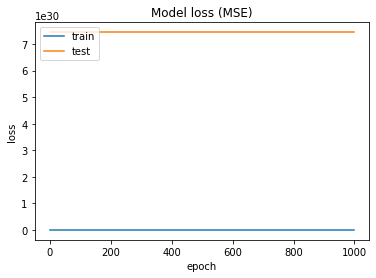

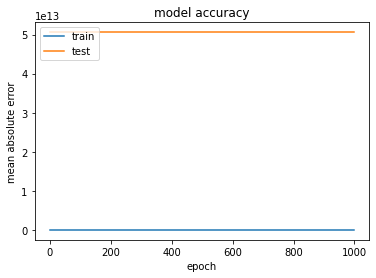

In [13]:
print('Really poor performance')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


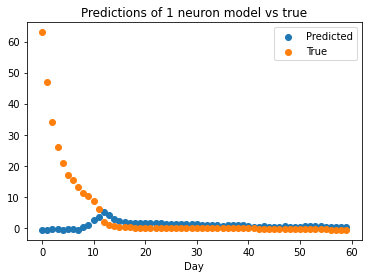

In [14]:
points = 60
df = X_train_df
predictions = model.predict(x=df.iloc[:, 3:], workers=16, use_multiprocessing=True).reshape(-1)[:points]
true_vals = df.iloc[:points, 0]
plt.scatter(range(points), predictions, label="Predicted")
plt.scatter(range(points), true_vals, label="True")
plt.legend()
plt.title('Predictions of 1 neuron model vs true')
plt.xlabel('Day')
plt.show()

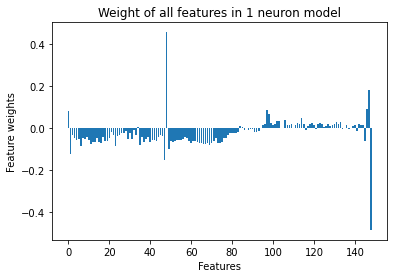

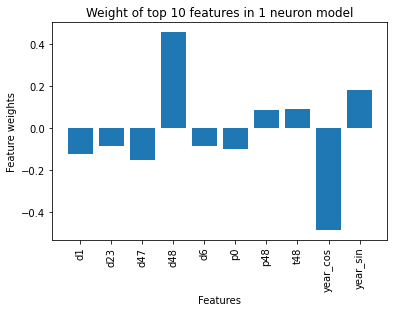

In [15]:
# based on https://www.tensorflow.org/tutorials/structured_data/time_series
cols = list(X_val_df)[3:]
plt.bar(x=range(len(cols)),
        height=model.layers[0].kernel[:, 0].numpy())
plt.title('Weight of all features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()

# top 10 features
top_num = 10
basic_coef_ord = np.argsort(np.absolute(model.layers[0].kernel[:, 0].numpy()))
new_cols = []
for idx in basic_coef_ord[-top_num:][::-1]:
    col_name = cols[idx]
    col_val = model.layers[0].kernel[:, 0].numpy()[idx]
    new_cols.append((col_name, col_val))
new_cols.sort(key=lambda x: x[0])
plt.bar(x=range(top_num),
        height=[b for a, b in new_cols])
axis = plt.gca()
axis.set_xticks(range(top_num))
_ = axis.set_xticklabels([a for a, b in new_cols], rotation=90)
plt.title(f'Weight of top {top_num} features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()


In [72]:
gc.collect()

0

In [78]:
complex_model_2 = Sequential([
    # dense layer 1
#     tf.keras.layers.Conv1D(32, 4, activation='relu',input_shape=np.array(X_val_df.columns[3:]).shape),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(1)
])
complex_model_2.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

complex_history_2 = complex_model_2.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, [0]], epochs=100,
                    batch_size=20000,
                    validation_split=0.2, verbose=1)

Epoch 1/100
30/30 [==============================] - 2s 47ms/step - loss: 23.0835 - mean_absolute_error: 3.0358 - val_loss: 81.7838 - val_mean_absolute_error: 2.6668
Epoch 2/100
30/30 [==============================] - 1s 31ms/step - loss: 5.8309 - mean_absolute_error: 1.4988 - val_loss: 3.8200 - val_mean_absolute_error: 1.1432
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 4.9189 - mean_absolute_error: 1.3102 - val_loss: 2.7497 - val_mean_absolute_error: 0.9922
Epoch 4/100
30/30 [==============================] - 1s 29ms/step - loss: 4.5480 - mean_absolute_error: 1.2285 - val_loss: 3.5966 - val_mean_absolute_error: 1.0358
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 4.3702 - mean_absolute_error: 1.1833 - val_loss: 2.4561 - val_mean_absolute_error: 0.8836
Epoch 6/100
30/30 [==============================] - 1s 31ms/step - loss: 4.2628 - mean_absolute_error: 1.1504 - val_loss: 2.9193 - val_mean_absolute_error: 0.9335
Epoch 7/100
30

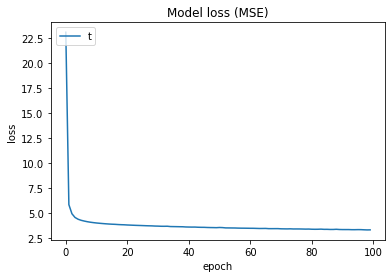

In [79]:
plt.plot(complex_history_2.history['loss'])
# plt.plot(complex_history_2.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'][0], loc='upper left')
plt.show()

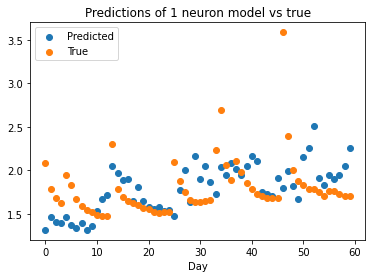

In [80]:
points = 60
df = X_val_df
predictions = complex_model_2.predict(x=df.iloc[:, 3:], workers=16, use_multiprocessing=True).reshape(-1)[:points]
true_vals = df.iloc[:points, 0]
plt.scatter(range(points), predictions, label="Predicted")
plt.scatter(range(points), true_vals, label="True")
plt.legend()
plt.title('Predictions of 1 neuron model vs true')
plt.xlabel('Day')
plt.show()

In [68]:
np.argmax(X_train_df.iloc[:, 0])

612495

In [69]:
np.max(X_train_df.iloc[:, 0])

817.9999999999811

In [70]:
X_train_df.iloc[612495,:]

y                   818
river          08086212
river_day          1917
d0                    0
d1                    0
                ...    
t46            0.721831
t47            0.683099
t48            0.274648
year_sin        0.99996
year_cos     0.00899908
Name: 274847, Length: 152, dtype: object

In [71]:
X_train_df.iloc[612495-2:612495+2,:]

,y,river,river_day,d0,d1,d2,d3,d4,d5,d6,...,t41,t42,t43,t44,t45,t46,t47,t48,year_sin,year_cos
274845,83.0,08086212,1915,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411972,0.411972,0.390845,0.334507,0.823944,0.429577,0.394366,0.721831,0.999058,0.043391
274846,562.0,08086212,1916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411972,0.390845,0.334507,0.823944,0.429577,0.394366,0.721831,0.683099,0.999657,0.026199
274847,818.0,08086212,1917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.390845,0.334507,0.823944,0.429577,0.394366,0.721831,0.683099,0.274648,0.999960,0.008999
274848,316.0,08086212,1918,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.334507,0.823944,0.429577,0.394366,0.721831,0.683099,0.274648,0.235915,0.999966,-0.008203


In [47]:
X_train_df.iloc[335593-2:335593+2,:]

,y,river,river_day,d0,d1,d2,d3,d4,d5,d6,...,t41,t42,t43,t44,t45,t46,t47,t48,year_sin,year_cos
561887,-0.40,02481000,1597,0.12,0.20,0.00,-0.16,-0.26,-0.32,-0.35,...,20.80,14.70,6.95,7.80,11.95,11.95,17.8,19.40,0.718400,-0.695631
561888,-0.39,02481000,1598,0.20,0.00,-0.16,-0.26,-0.32,-0.35,-0.38,...,14.70,6.95,7.80,11.95,11.95,17.80,19.4,17.20,0.706327,-0.707886
561889,-0.38,02481000,1599,0.00,-0.16,-0.26,-0.32,-0.35,-0.38,-0.42,...,6.95,7.80,11.95,11.95,17.80,19.40,17.2,17.20,0.694046,-0.719931
561890,-0.38,02481000,1600,-0.16,-0.26,-0.32,-0.35,-0.38,-0.42,-0.43,...,7.80,11.95,11.95,17.80,19.40,17.20,17.2,19.45,0.681559,-0.731763


In [58]:
rd_d = X_train_df.iloc[335593,3:3+49].to_numpy()
rd_min, rd_max = np.min(rd_d), np.max(rd_d)